In [ ]:
import os
import time
import random

import torch
import torchvision
from torchvision import datasets
from torchvision.models import resnet18
from torch.utils.data import DataLoader, SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from google.colab import files

In [ ]:
RANDOM_SEED = 10
BATCH_SIZE = 256
NUM_EPOCHS = 10
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
!nvidia-smi

Thu Nov 11 16:12:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    26W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
os.environ["PL_GLOBAL_SEED"] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# MNIST Dataset

In [ ]:
def get_mnist_dataloaders(batch_size, validation_fraction=None, data_transform=None):
  """
    Download MNIST dataset and prepare train, validation, and test dataloaders.

    Parameters
    ----------
    batch_size: Number of samples in each mini batch.
    validation_fraction: Percentage of train data to be used as validation data.
    data_transform: Transformations to data samples.
  """

  train_dataset = datasets.MNIST(root='data', train=True, transform=data_transform, download=True)
  valid_dataset = datasets.MNIST(root='data', train=True, transform=data_transform)
  test_dataset = datasets.MNIST(root='data', train=False, transform=data_transform)

  if validation_fraction is not None:
      num = int(validation_fraction * 60000)
      train_indices = torch.arange(0, 60000 - num)
      valid_indices = torch.arange(60000 - num, 60000)

      train_sampler = SubsetRandomSampler(train_indices)
      valid_sampler = SubsetRandomSampler(valid_indices)

      valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, sampler=valid_sampler)
      train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_sampler)

  else:
      train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)

  test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  if validation_fraction is None:
      return train_loader, test_loader
  else:
      return train_loader, valid_loader, test_loader

In [ ]:
resize_transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((32, 32)),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5,), (0.5,))])

In [ ]:
train_loader, valid_loader, test_loader = get_mnist_dataloaders(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    data_transform=resize_transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([256, 1, 32, 32])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([2, 3, 7, 3, 2, 4, 3, 8, 5, 0])


# Model

In [ ]:
class LeNet5(torch.nn.Module):

  def __init__(self, num_classes):
      super().__init__()
      
      self.num_classes = num_classes
      self.layer1 = torch.nn.Sequential(
          torch.nn.Conv2d(1, 6, kernel_size=5),
          torch.nn.Tanh(),
          torch.nn.AvgPool2d(kernel_size=2)
      )
      self.layer2 = torch.nn.Sequential(
          torch.nn.Conv2d(6, 16, kernel_size=5),
          torch.nn.Tanh(),
          torch.nn.AvgPool2d(kernel_size=2)
      )
      self.layer3 = torch.nn.Sequential(
          torch.nn.Linear(16*5*5, 120),
          torch.nn.Tanh()
      )
      self.layer4 = torch.nn.Sequential(
          torch.nn.Linear(120, 84),
          torch.nn.Tanh()
      )
      self.output = torch.nn.Linear(84, num_classes)

  def forward(self, x):
      x = self.layer1(x)
      x = self.layer2(x)
      x = torch.flatten(x, 1)
      x = self.layer3(x)
      x = self.layer4(x)
      logits = self.output(x)
      return logits

In [ ]:
model = LeNet5(num_classes=10)
model = model.to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.8)

# Training

In [ ]:
def compute_accuracy(model, data_loader, device):
  """
  Computes model's prediction on provided data.

  Parameters
  ----------
  model: Prediction model.
  data_loader: Data for computing accuracy.
  device: CPU or GPU
  """
  with torch.no_grad():
      correct_pred, num_examples = 0, 0

      for i, (features, targets) in enumerate(data_loader):
          features = features.to(device)
          targets = targets.float().to(device)

          logits = model(features)
          _, predicted_labels = torch.max(logits, 1)

          num_examples += targets.size(0)
          correct_pred += (predicted_labels == targets).sum()
          
  return correct_pred.float()/num_examples * 100

In [ ]:
def train_model(model, num_epochs, train_loader,
                valid_loader, test_loader, optimizer,
                device, logging_interval=50,
                scheduler=None):
  """
  Training model function.

  Parameters
  ----------
  model: Model to be trained.
  num_epochs: Number of training epochs.
  train_loader: Training data loader.
  valid_loader: Validation data loader.
  test_loader: Test data loader.
  optimizer: Optimizer function for training.
  device: CPU or GPU
  """

  start_time = time.time()
  
  for epoch in range(num_epochs):

      model.train()
      for batch_idx, (features, targets) in enumerate(train_loader):

          features = features.to(device)
          targets = targets.to(device)

          # ## FORWARD AND BACK PROP
          logits = model(features)
          loss = torch.nn.functional.cross_entropy(logits, targets)
          optimizer.zero_grad()

          loss.backward()

          # ## UPDATE MODEL PARAMETERS
          optimizer.step()

          # ## LOGGING
          if not batch_idx % logging_interval:
              print(f'Epoch: {epoch+1:02d}/{num_epochs:02d} '
                    f'| Batch {batch_idx:01d}/{len(train_loader):01d} '
                    f'| Loss: {loss:.4f}')

      model.eval()
      with torch.no_grad(): 
          train_acc = compute_accuracy(model, train_loader, device=device)
          valid_acc = compute_accuracy(model, valid_loader, device=device)
          print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                f'| Train: {train_acc :.2f}% '
                f'| Validation: {valid_acc :.2f}%')

      elapsed = (time.time() - start_time)/60
      print(f'Time elapsed: {elapsed:.2f} mins\n')
      
      if scheduler is not None:
        scheduler.step()
      

  elapsed = (time.time() - start_time)/60
  print(f'Total Training Time: {elapsed:.2f} min')

  test_acc = compute_accuracy(model, test_loader, device=device)
  print(f'Test accuracy {test_acc :.2f}%')

In [ ]:
train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=100)

Epoch: 01/10 | Batch 0/211 | Loss: 2.3178
Epoch: 01/10 | Batch 100/211 | Loss: 0.2265
Epoch: 01/10 | Batch 200/211 | Loss: 0.1633
Epoch: 001/010 | Train: 96.60% | Validation: 97.13%
Time elapsed: 0.58 mins

Epoch: 02/10 | Batch 0/211 | Loss: 0.0811
Epoch: 02/10 | Batch 100/211 | Loss: 0.1212
Epoch: 02/10 | Batch 200/211 | Loss: 0.1074
Epoch: 002/010 | Train: 96.66% | Validation: 97.08%
Time elapsed: 1.15 mins

Epoch: 03/10 | Batch 0/211 | Loss: 0.0634
Epoch: 03/10 | Batch 100/211 | Loss: 0.0821
Epoch: 03/10 | Batch 200/211 | Loss: 0.0961
Epoch: 003/010 | Train: 97.56% | Validation: 97.82%
Time elapsed: 1.73 mins

Epoch: 04/10 | Batch 0/211 | Loss: 0.0394
Epoch: 04/10 | Batch 100/211 | Loss: 0.1005
Epoch: 04/10 | Batch 200/211 | Loss: 0.0921
Epoch: 004/010 | Train: 97.91% | Validation: 97.50%
Time elapsed: 2.29 mins

Epoch: 05/10 | Batch 0/211 | Loss: 0.0548
Epoch: 05/10 | Batch 100/211 | Loss: 0.0283
Epoch: 05/10 | Batch 200/211 | Loss: 0.0388
Epoch: 005/010 | Train: 97.40% | Validatio

In [ ]:
torch.save(model.state_dict(), 'LeNet5.pth')

# download checkpoint file
files.download('LeNet5.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Top-k Neuron Patterns

In [ ]:
# Please execute the first cell of 'Model' section containing LeNet5 class.

state_dict = torch.load('LeNet5.pth')
model = LeNet5(num_classes=10)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
resize_transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((32, 32)),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5,), (0.5,))])

In [ ]:
train_dataset = datasets.MNIST(root='data', train=True, transform=resize_transform, download=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=resize_transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=1, drop_last=True, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
print(f'Training data size: {len(train_loader)}')
print(f'Testing data size: {len(test_loader)}')

Training data size: 60000
Testing data size: 10000


In [ ]:
activation = {} # Stores the top-k nodes' indices of a layer
def get_activation(name, k):
  """
  Selects and stores k neurons with highest output values.
  Adapted from https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/5

  Parameters
  ----------
  name: Name of the layer whose activation values are under investigation.
  k: Number of highest output value nodes to be selected. 
  """

  def hook(layer, input, output):
    activation[name] = torch.topk(output.detach().flatten(), k, largest=True, sorted=True).indices.tolist()
  return hook

In [ ]:
def compute_tknp_coverage(model, data_loader, k):
  """
  Computes the top-K Neuron Patterns coverage criteria.

  Parameters
  ----------
  model: Prediction
  data_loader: Data loader corresponding to test data.
  k: Number of highest output value nodes to be selected.
  """
  
  top_node_patterns = set() # Store all top-k nodes' sequence patterns
  model = model.to(DEVICE)

  for layer in model.named_children():
    layer[1].register_forward_hook(get_activation(layer[0], k)) # Registers a forward hook

  for i, (features, targets) in enumerate(tqdm(data_loader, desc=f'For k = {k}')):
    features = features.to(DEVICE)
    _ = model(features) # Forward propagation on a test data sample
    
    top_nodes = []
    for layer in model.named_children():
      indices = activation[layer[0]]
      top_nodes.append(tuple(indices))

    top_node_patterns.add(tuple(top_nodes))

  return len(top_node_patterns)

In [ ]:
tknp_coverage = {}
for k in [1, 2, 3, 5]:
  tknp_coverage[str(k)] = compute_tknp_coverage(model, test_loader, k)

For k = 5: 100%|██████████| 10000/10000 [00:49<00:00, 202.23it/s]


In [ ]:
tknp_coverage

{'1': 7679, '2': 9919, '3': 9997, '5': 10000}

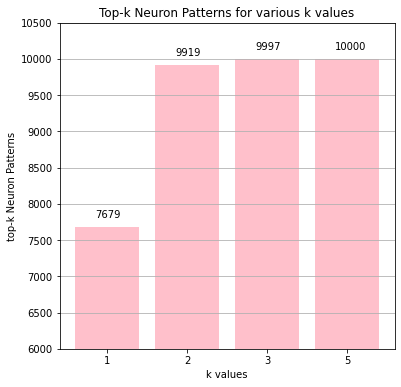

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 6)

ax.bar(tknp_coverage.keys(), tknp_coverage.values(), zorder=0, color='pink')
ax.grid(axis='y')
ax.set_ylim([6000, 10500])
ax.set_xlabel('k values')
ax.set_ylabel('top-k Neuron Patterns')
ax.set_title('Top-k Neuron Patterns for various k values')

for index, value in enumerate(tknp_coverage.values()):
    plt.text(index-0.15, value + 130, str(value))

plt.show()